# sklearn-pandas

1.  A way to map `DataFrame` columns to transformations, which are later
    recombined into features.
2.  A couple of special transformers that work well with pandas inputs:
    `CategoricalImputer` and `FunctionTransformer`.

Installation
============

You can install `sklearn-pandas` with `pip`:

In [3]:
#!pip install -U sklearn-pandas

Requirement already up-to-date: sklearn-pandas in /Users/brandonanhorn19/anaconda3/lib/python3.6/site-packages (1.8.0)


Usage
=====

Import
------

In [2]:
from sklearn_pandas import DataFrameMapper

For these examples, we'll also use pandas, numpy, and sklearn:

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

import sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer

SyntaxError: invalid syntax (<ipython-input-5-ad1e7737b7f3>, line 4)

Load some Data
--------------

Normally we'll read the data from a file, but for demonstration
purposes we'll create a data frame from a Python dict:

In [4]:
data = pd.DataFrame([
    ['Justin Trudeau', 'Liberal', 34.1, 167, 'Left'],
    ['Andrew Scheer', 'Conservative', 34.4, 139, 'Right'],
    ['Jagmeet Singh', 'NDP', 13.8, 16, 'Left'],
    ['Elizabeth May', 'Green', 9.5, 4, 'Left']
], columns=['leader', 'party', 'polling', 'seats', 'leaning'])

data

,leader,party,polling,seats,leaning
0,Justin Trudeau,Liberal,34.1,167,Left
1,Andrew Scheer,Conservative,34.4,139,Right
2,Jagmeet Singh,NDP,13.8,16,Left
3,Elizabeth May,Green,9.5,4,Left


In [5]:
ss = StandardScaler()

ss.fit_transform(data[['seats']])

array([[ 1.18246404],
       [ 0.79522435],
       [-0.90586426],
       [-1.07182413]])

In [6]:
x = np.array([20, 1, 3, 19, 42]).reshape(-1, 1)
ss = StandardScaler()
ss.fit_transform(x)

array([[ 0.20318564],
       [-1.08365674],
       [-0.94819965],
       [ 0.13545709],
       [ 1.69321365]])

In [7]:
lb = LabelBinarizer()

lb.fit_transform(data['party'])

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

Transformation Mapping
======================

Map the Columns to Transformations
----------------------------------

The mapper takes a list of tuples. The first element of each tuple is a
column name from the pandas DataFrame, or a list containing one or
multiple columns (we will see an example with multiple columns later).
The second element is an object which will perform the transformation
which will be applied to that column. The third one is optional and is a
dictionary containing the transformation options, if applicable (see
"custom column names for transformed features" below).

Let's see an example:

In [8]:
mapper = DataFrameMapper([
    ('leader', LabelBinarizer()),
    ('party', LabelBinarizer()),
    ('polling', None),
    (['seats'], StandardScaler()),
    ('leaning', LabelEncoder())
], df_out=True)

In [9]:
mapper.fit(data)

DataFrameMapper(default=False, df_out=True,
                features=[('leader',
                           LabelBinarizer(neg_label=0, pos_label=1,
                                          sparse_output=False)),
                          ('party',
                           LabelBinarizer(neg_label=0, pos_label=1,
                                          sparse_output=False)),
                          ('polling', None),
                          (['seats'],
                           StandardScaler(copy=True, with_mean=True,
                                          with_std=True)),
                          ('leaning', LabelEncoder())],
                input_df=False, sparse=False)

In [10]:
mapper.transform(data)

,leader_Andrew Scheer,leader_Elizabeth May,leader_Jagmeet Singh,leader_Justin Trudeau,party_Conservative,party_Green,party_Liberal,party_NDP,polling,seats,leaning
0,0,0,0,1,0,0,1,0,34.1,1.182464,0
1,1,0,0,0,1,0,0,0,34.4,0.795224,1
2,0,0,1,0,0,0,0,1,13.8,-0.905864,0
3,0,1,0,0,0,1,0,0,9.5,-1.071824,0


In [11]:
mapper.features[-1][1].classes_

array(['Left', 'Right'], dtype=object)

In [12]:
data[0:1].to_dict(orient='list')

{'leader': ['Justin Trudeau'],
 'party': ['Liberal'],
 'polling': [34.1],
 'seats': [167],
 'leaning': ['Left']}

In [13]:
new = pd.DataFrame({
    'leader': ['Maxime Bernier'],
    'party': ['PPC'],
    'polling': [2.6],
    'seats': [0],
    'leaning': ['Right']
})

In [14]:
mapper.transform(new)

,leader_Andrew Scheer,leader_Elizabeth May,leader_Jagmeet Singh,leader_Justin Trudeau,party_Conservative,party_Green,party_Liberal,party_NDP,polling,seats,leaning
0,0,0,0,0,0,0,0,0,2.6,-1.127144,1


The difference between specifying the column selector as `'column'` (as
a simple string) and `['column']` (as a list with one element) is the
shape of the array that is passed to the transformer. In the first case,
a one dimensional array will be passed, while in the second case it will
be a 2-dimensional array with one column, i.e. a column vector.

Be aware that some transformers expect a 1-dimensional input (the
label-oriented ones) while some others, like `OneHotEncoder` or
`Imputer`, expect 2-dimensional input, with the shape
`[n_samples, n_features]`.

Test the Transformation
-----------------------

We can use the `fit_transform` shortcut to both fit the model and see
what transformed data looks like. In this and the other examples, output
is rounded to two digits with `np.round` to account for rounding errors
on different hardware:

Output features names
---------------------

In certain cases, like when studying the feature importances for some
model, we want to be able to associate the original features to the ones
generated by the dataframe mapper. We can do so by inspecting the
automatically generated `transformed_names_` attribute of the mapper
after transformation:

In [15]:
mapper.transformed_names_

['leader_Andrew Scheer',
 'leader_Elizabeth May',
 'leader_Jagmeet Singh',
 'leader_Justin Trudeau',
 'party_Conservative',
 'party_Green',
 'party_Liberal',
 'party_NDP',
 'polling',
 'seats',
 'leaning']

Custom column names for transformed features
--------------------------------------------

We can provide a custom name for the transformed features, to be used
instead of the automatically generated one, by specifying it as the
third argument of the feature definition:

In [16]:
mapper2 = DataFrameMapper([
    ('leader', LabelBinarizer(), {'alias': 'name'}),
    ('polling', None),
], df_out=True)

mapper2.fit_transform(data)

,name_Andrew Scheer,name_Elizabeth May,name_Jagmeet Singh,name_Justin Trudeau,polling
0,0,0,0,1,34.1
1,1,0,0,0,34.4
2,0,0,1,0,13.8
3,0,1,0,0,9.5


In [17]:
mapper3 = DataFrameMapper([
    ('leader', LabelBinarizer(), {'alias': 'name'}),
    ('polling', None),
])

mapper3.fit_transform(data)

mapper.transformed_names_

['leader_Andrew Scheer',
 'leader_Elizabeth May',
 'leader_Jagmeet Singh',
 'leader_Justin Trudeau',
 'party_Conservative',
 'party_Green',
 'party_Liberal',
 'party_NDP',
 'polling',
 'seats',
 'leaning']

In [18]:
data.columns

Index(['leader', 'party', 'polling', 'seats', 'leaning'], dtype='object')

Passing Series/DataFrames to the transformers
---------------------------------------------

By default the transformers are passed a numpy array of the selected
columns as input. This is because `sklearn` transformers are
historically designed to work with numpy arrays, not with pandas
dataframes, even though their basic indexing interfaces are similar.

However we can pass a dataframe/series to the transformers to handle
custom cases initializing the dataframe mapper with `input_df=True`:

In [22]:
dates = pd.DataFrame({
    'dates': ['2019-09-18', '2019-08-26', '2019-09-16']
})

dates['dates'] = dates['dates'].apply(pd.to_datetime)

dates['dates'].dt.day

0    18
1    26
2    16
Name: dates, dtype: int64

In [23]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        dt = X.dt
        return pd.concat([dt.year, dt.month, dt.day], axis=1)

In [24]:
mapperd = DataFrameMapper([
    ('dates', DateEncoder())
], input_df=True, df_out=True)

mapperd.fit_transform(dates)

,dates_0,dates_1,dates_2
0,2019,9,18
1,2019,8,26
2,2019,9,16


In [25]:
mapperd = DataFrameMapper([
    ('dates', DateEncoder(), {'input_df': True})
], df_out=True)

mapperd.fit_transform(dates)

,dates_0,dates_1,dates_2
0,2019,9,18
1,2019,8,26
2,2019,9,16


In [26]:
from sklearn.preprocessing import FunctionTransformer

In [27]:
data.head()

,leader,party,polling,seats,leaning
0,Justin Trudeau,Liberal,34.1,167,Left
1,Andrew Scheer,Conservative,34.4,139,Right
2,Jagmeet Singh,NDP,13.8,16,Left
3,Elizabeth May,Green,9.5,4,Left


In [28]:
def convert_number_to_percent(x):
    return x / 100

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
mapper = DataFrameMapper([
    (['polling'], FunctionTransformer(lambda x: x / 100)),
    (['seats'], StandardScaler())
], df_out=True)

mapper.fit_transform(data)

,polling,seats
0,0.341,1.182464
1,0.344,0.795224
2,0.138,-0.905864
3,0.095,-1.071824


Multiple transformers for the same column
-----------------------------------------

Multiple transformers can be applied to the same column specifying them
in a list:

In [31]:
baseball = pd.DataFrame({
    'age': [24, None, 27, 31, 36, 28],
    'hr': [13, 16, 24, 9, 8, 17]
})

baseball

,age,hr
0,24.0,13
1,NaN,16
2,27.0,24
3,31.0,9
4,36.0,8
5,28.0,17


In [32]:
si = SimpleImputer()
si.fit_transform(baseball[['age']])

array([[24. ],
       [29.2],
       [27. ],
       [31. ],
       [36. ],
       [28. ]])

In [33]:
from sklearn.preprocessing import PolynomialFeatures

mapperb = DataFrameMapper([
    (['age'], [
        SimpleImputer(strategy='mean'), 
        PolynomialFeatures(include_bias=False), 
        StandardScaler()
    ])
], df_out=True)

mapperb.fit_transform(baseball)

,age_x0,age_x0^2
0,-1.399793,-1.290961
1,0.000000,-0.061339
2,-0.592220,-0.610899
3,0.484544,0.420304
4,1.830498,1.909327
5,-0.323029,-0.366433


Columns that don't need any transformation
------------------------------------------

Only columns that are listed in the DataFrameMapper are kept. To keep a
column but don't apply any transformation to it, use None as
transformer:

In [34]:
mapperb = DataFrameMapper([
    (['age'], [SimpleImputer(strategy='mean'), PolynomialFeatures(include_bias=False), StandardScaler()]),
    ('hr', None)
], df_out=True)

mapperb.fit_transform(baseball)

,age_x0,age_x0^2,hr
0,-1.399793,-1.290961,13
1,0.000000,-0.061339,16
2,-0.592220,-0.610899,24
3,0.484544,0.420304,9
4,1.830498,1.909327,8
5,-0.323029,-0.366433,17


`CategoricalImputer`
--------------------

Since the `scikit-learn` `Imputer` transformer currently only works with
numbers, `sklearn-pandas` provides an equivalent helper transformer that
works with strings, substituting null values with the most frequent
value in that column. Alternatively, you can specify a fixed value to
use.

In [35]:
from sklearn_pandas import CategoricalImputer

fake_data = np.array(['a', 'b', 'b', 'b', 'b', 'a', None], dtype=object)
fake_data
imputer = CategoricalImputer()
imputer.fit_transform(fake_data)

imputer = CategoricalImputer(strategy='constant', fill_value='other')
imputer.fit_transform(fake_data)

array(['a', 'b', 'b', 'b', 'b', 'a', 'other'], dtype=object)

`FunctionTransformer`
---------------------

Often one wants to apply simple transformations to data such as
`np.log`. `FunctionTransformer` is a simple wrapper that takes any
function and applies vectorization so that it can be used as a
transformer.

In [36]:
from sklearn.preprocessing import FunctionTransformer

income = np.array([100_000, 80_000, 45_000, 56_000, 230_000, 2_700_000, 13_000])
income

StandardScaler().fit_transform(income.reshape(-1, 1))

transformer = FunctionTransformer(np.log10, inverse_func=lambda x: 10**x)

transformer.fit(income.reshape(-1, 1))
tx = transformer.transform(income.reshape(-1, 1))


transformer.inverse_transform(tx)

array([[ 100000.],
       [  80000.],
       [  45000.],
       [  56000.],
       [ 230000.],
       [2700000.],
       [  13000.]])

### Baseball

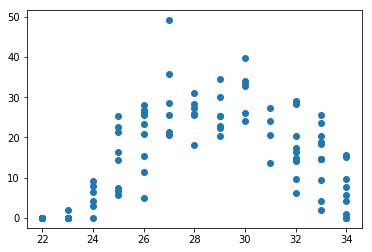

In [38]:
x = np.random.randint(low=22, high=35, size=100)
y = [-((xi - 29)**2) + 30 for xi in x]
y = np.random.normal(loc=0, scale=6, size=100) + y
y = np.clip(y, a_min=0, a_max=50)

%matplotlib inline

from matplotlib import pyplot as plt

plt.scatter(x, y)

In [39]:
df = pd.DataFrame({'age': x, 'hr': y})
df.head()

,age,hr
0,32,17.421543
1,23,0.000000
2,22,0.000000
3,34,0.000000
4,32,16.340217


In [40]:
from sklearn.model_selection import train_test_split

In [41]:
target = 'hr'
y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [42]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

-0.31463626053684957

In [43]:
# option A
mapper = DataFrameMapper([
    (['age'], [PolynomialFeatures(include_bias=False), StandardScaler()])
])

Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

model2 = LinearRegression()
model2.fit(Z_train, y_train)
model2.score(Z_test, y_test)

0.5068588293150396

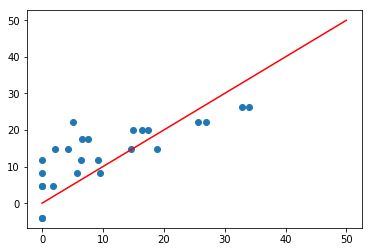

In [44]:
pred = pd.DataFrame({
    'yhat': model2.predict(Z_test),
    'ytrue': y_test
})

plt.scatter(pred.ytrue, pred.yhat)
plt.plot([0, 50], [0, 50], c='r')


In [45]:
# option B

from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    DataFrameMapper([
        (['age'], [PolynomialFeatures(include_bias=False), StandardScaler()])
    ]), 
    LinearRegression()
)

mapper = DataFrameMapper([
    (['age'], [PolynomialFeatures(include_bias=False), StandardScaler()])
])

model = LinearRegression()

pipe = make_pipeline(mapper, model)

In [46]:
pipe.fit(X_train, y_train)
pipe.predict(X_test)

array([11.7905539 , 14.75502469, 17.62922542,  4.57456091, 19.93492493,
        8.19780298,  8.19780298, 11.7905539 , -4.01875356, 19.93492493,
       22.09057548, 22.09057548, 17.62922542, 14.75502469, 26.16276099,
       19.93492493,  8.19780298, 14.75502469,  4.57456091,  4.57456091,
       -4.01875356, 26.16276099, 11.7905539 , 14.75502469, 22.09057548])

In [47]:
pipe.predict(pd.DataFrame({'age': [34]}))

array([8.19780298])